In [ ]:
from pathlib import Path
from typing import Sequence

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pyvista as pv
import skimage
from einops import rearrange
from tqdm import tqdm


# pv.set_jupyter_backend("static")

datadir = Path("../data/SIM")


def read_SIM_data(filepath: Path | str):
    f = h5py.File(filepath)
    data = f["Data"][:]
    pixel_sizes = f["Data"].attrs["pixel_sizes"]
    dtype = data.dtype
    if dtype.kind == "u":
        data = data / np.iinfo(dtype).max
    return data, pixel_sizes


In [56]:
data, pixel_sizes = read_SIM_data(datadir / "alpha-actinin/Image2_SIM2.h5")
data = data[..., 0:1024, 1024:2048]
data_chunks = rearrange(data, "C Z (Ny Y) (Nx X) -> (Ny Nx) C Z Y X", Ny=2, Nx=2)
data = data_chunks[0]

In [57]:
data.shape

(2, 45, 512, 512)

In [75]:
q = np.quantile(data, 0.7, axis=(-1, -2))
m = np.mean(data, axis=(-1, -2))

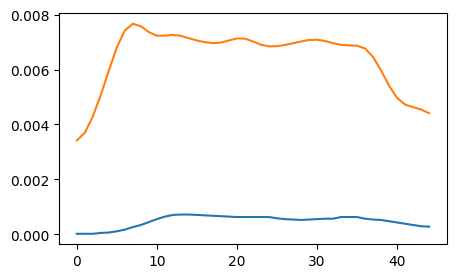

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.plot(q[0])
ax.plot(m[0])

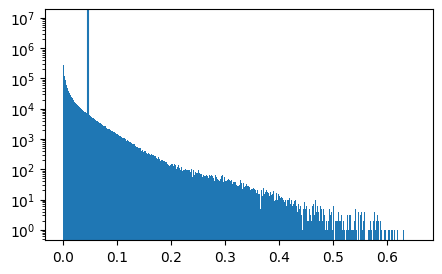

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(data[1, :].flatten(), bins=1000)
# ax.set_yscale("log")
ax.axvline(skimage.filters.threshold_otsu(data[1, :]))
ax.set_yscale("log")

In [76]:
thresholds

array([0.02975712, 0.11079778])

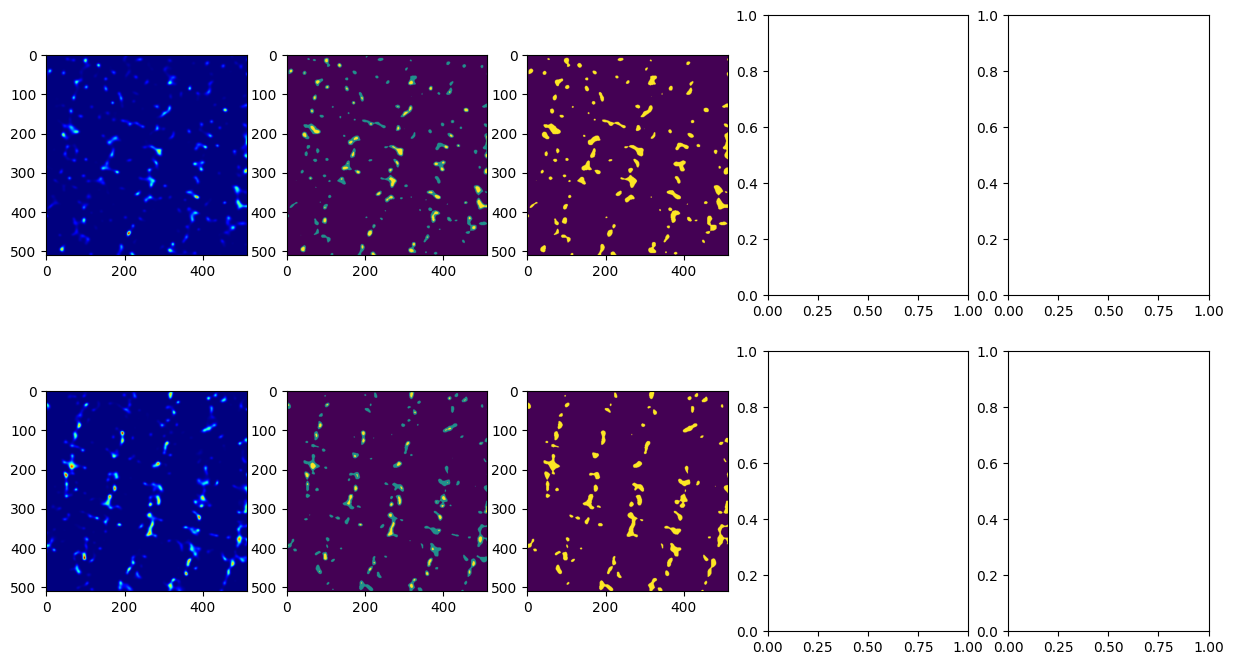

In [4]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i, axes_row in enumerate(axes):
    img = data[i]
    thresholds = skimage.filters.threshold_multiotsu(img)
    bin = skimage.filters.apply_hysteresis_threshold(img, *thresholds)
    # seg = skimage.segmentation.morphological_chan_vese(
    #     img, num_iter=40, init_level_set=img > thresholds[0], smoothing=1
    # )

    axes_row[0].imshow(img[10], cmap="jet")
    axes_row[1].imshow(np.digitize(img, bins=thresholds)[10])
    axes_row[2].imshow(bin[10])
    # axes_row[3].imshow(seg[10])
    # axes_row[4].imshow(seg[10] - bin[10])


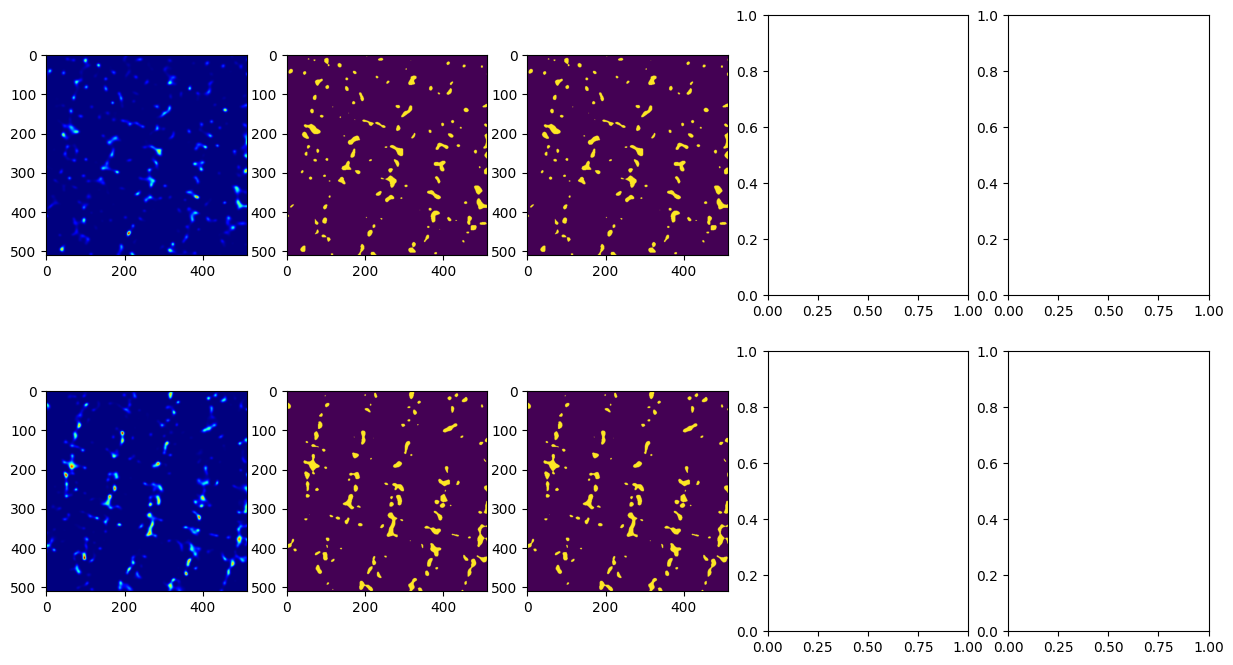

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))

for i, axes_row in enumerate(axes):
    img = data[i]
    threshold = skimage.filters.threshold_otsu(img)
    bin = skimage.filters.apply_hysteresis_threshold(img, 0.75 * threshold, threshold)
    # seg = skimage.segmentation.morphological_chan_vese(
    #     img, num_iter=40, init_level_set=img > thresholds[0], smoothing=1
    # )

    axes_row[0].imshow(img[10], cmap="jet")
    axes_row[1].imshow(img[10] > 0.75 * threshold)
    axes_row[2].imshow(bin[10])
    # axes_row[3].imshow(seg[10])
    # axes_row[4].imshow(seg[10] - bin[10])


In [78]:
pixel_sizes / np.min(pixel_sizes)

array([8.046441, 1.      , 1.      ], dtype=float32)

In [79]:
out = skimage.transform.rescale(
    data[0], scale=pixel_sizes / np.min(pixel_sizes), order=1
)

In [80]:
out.shape

(362, 512, 512)

In [95]:
def segment_image(img: np.ndarray):
    bin = img > skimage.filters.threshold_otsu(img)
    return skimage.segmentation.morphological_chan_vese(
        img, num_iter=40, init_level_set=bin, smoothing=2
    )


actinin_segmented = np.stack([segment_image(img) for img in tqdm(data[0])], axis=0)
actinin_segmented.shape

100%|██████████| 45/45 [06:06<00:00,  8.14s/it]


(45, 1024, 1024)

In [82]:
# img_desmin, img_actinin = data[0], data[1]

img_desmin = skimage.transform.rescale(
    data[0], scale=pixel_sizes / np.min(pixel_sizes), order=1
)
img_actinin = skimage.transform.rescale(
    data[1], scale=pixel_sizes / np.min(pixel_sizes), order=1
)


def binarize_zstack(img):
    return skimage.filters.apply_hysteresis_threshold(
        img, *skimage.filters.threshold_multiotsu(img)
    )


desmin_segmented = binarize_zstack(img_desmin)
actinin_segmented = binarize_zstack(img_actinin)
# otsu = skimage.filters.threshold_otsu(img)
# actinin_segmented = skimage.filters.apply_hysteresis_threshold(img, 0.7 * otsu, otsu)


In [25]:
actinin_segmented.shape

(45, 512, 512)

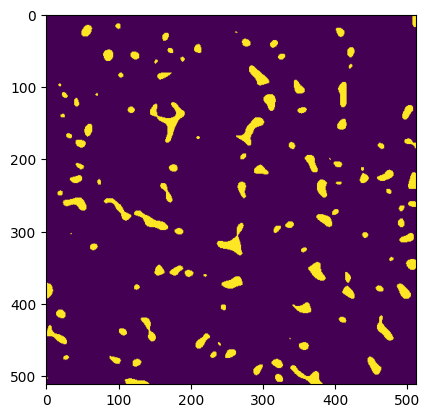

In [26]:
plt.imshow(actinin_segmented[20])

In [100]:
verts, faces, normals, values = skimage.measure.marching_cubes(
    np.permute_dims(actinin_segmented, (2, 1, 0)),
    level=0.5,
    spacing=np.ones_like(pixel_sizes) * np.min(pixel_sizes),
)
mesh_actinin = pv.PolyData.from_regular_faces(verts, faces)

verts, faces, normals, values = skimage.measure.marching_cubes(
    np.permute_dims(desmin_segmented, (2, 1, 0)),
    level=0.5,
    spacing=np.ones_like(pixel_sizes) * np.min(pixel_sizes),
)
mesh_desmin = pv.PolyData.from_regular_faces(verts, faces)

In [28]:
verts.shape

(403634, 3)

In [104]:
mesh = pv.PolyData.from_regular_faces(verts, faces)

pl = pv.Plotter(notebook=True, window_size=(1000, 1000))
pl.add_mesh(
    mesh_desmin,
    color="#FF0000",
    show_scalar_bar=False,
)

pl.add_mesh(
    mesh_actinin,
    color="#00FF00",
    show_scalar_bar=False,
)
pl.set_background("black")
# pl.view_xy()
pl.show()

Widget(value='<iframe src="http://localhost:45465/index.html?ui=P_0x7f3ce7e91610_32&reconnect=auto" class="pyv…

In [95]:
skeleton_desmin = skimage.morphology.skeletonize(desmin_segmented)
skeleton_actinin = skimage.morphology.skeletonize(actinin_segmented)


In [96]:
skeleton_desmin = skimage.morphology.binary_dilation(
    skeleton_desmin, skimage.morphology.ball(radius=2)
)
skeleton_actinin = skimage.morphology.binary_dilation(
    skeleton_actinin, skimage.morphology.ball(radius=2)
)

In [ ]:
def voxels_to_pyvista(
    voxels: np.ndarray, spacing: Sequence[float] | None = None, name: str = "scalars"
) -> pv.ImageData:
    if spacing is None:
        spacing = np.ones((voxels.ndim,))

    if len(spacing) != voxels.ndim:
        raise ValueError(
            "spacing must have length corresponding to the dimensionality of voxels."
        )
    grid = pv.ImageData(dimensions=[s + 1 for s in voxels.shape], spacing=spacing)
    grid.cell_data[name] = voxels.flatten(order="F")
    return grid


In [98]:
skeleton_actinin_voxels = voxels_to_pyvista(
    skeleton_actinin, np.ones_like(pixel_sizes) * np.min(pixel_sizes)
).threshold(0.5)
skeleton_desmin_voxels = voxels_to_pyvista(
    skeleton_desmin, np.ones_like(pixel_sizes) * np.min(pixel_sizes)
).threshold(0.5)

In [99]:
pl = pv.Plotter(notebook=True, window_size=(700, 700))
actor = pl.add_mesh(
    skeleton_desmin_voxels,
    cmap=["#FF0000"],
    show_scalar_bar=False,
)
actor = pl.add_mesh(
    skeleton_actinin_voxels,
    cmap=["#00FF00"],
    show_scalar_bar=False,
)
pl.set_background(color="black")
axis = pl.show_bounds(
    color="white",
    grid=None,
    bold=False,
    font_size=22,
    font_family="arial",
    padding=0.0,
    use_3d_text=False,
)

pl.show()

Widget(value='<iframe src="http://localhost:45465/index.html?ui=P_0x7f3e7587a780_28&reconnect=auto" class="pyv…

In [9]:
thresholds

NameError: name 'thresholds' is not defined